# Dense 3D Face Correspondence

In [5]:
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["NUMEXPR_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 

In [6]:

import numpy as np
import re
import threading
import cv2
import ipyvolume as ipv
import scipy
from math import cos, sin
from scipy import meshgrid, interpolate
import pdb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull, Delaunay

# THRESHOLDS
rho = 0.5
eigen_ratio_threshold = 5000

## Read each face data parallely

In [4]:
def read_wrl(file_path, var_name):
    global points
    holder = []
    with open(file_path, "r") as vrml:
        for line in vrml:
            a = line.strip().strip(",").split()
            if len(a) == 3:
                try:
                    holder.append(list(map(float, a)))
                except:
                    pass
    x,y,z = zip(*holder)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    points[var_name] = np.array(holder)



In [4]:
file_path1 = "F0001/F0001_AN01WH_F3D.wrl"
file_path2 = "F0001/F0001_DI03WH_F3D.wrl"
points = {}

thread1 = threading.Thread(target=read_wrl, args=(file_path1, "points1"))
thread2 = threading.Thread(target=read_wrl, args=(file_path2, "points2"))
thread1.start() 
thread2.start() 


In [5]:
points

{}

In [16]:
%%timeit
file_paths = {
    "path1": "F0001/F0001_AN01WH_F3D.wrl",
    "path2": "F0001/F0001_AN02WH_F3D.wrl",
    "path3": "F0001/F0001_AN03WH_F3D.wrl",
    "path4": "F0001/F0001_AN04WH_F3D.wrl",
    "path5": "F0001/F0001_DI01WH_F3D.wrl",
    "path6": "F0001/F0001_DI02WH_F3D.wrl",
    "path7": "F0001/F0001_DI03WH_F3D.wrl",
    "path8": "F0001/F0001_DI04WH_F3D.wrl",
}
points = {}
for i in range(1, len(file_paths)+1):
    thread = threading.Thread(target=read_wrl, args=(file_paths["path" + str(i)], "face" + str(i)))
    thread.start()


195 ms ± 6.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
points

{'face4': array([[ 43.3909, -66.4114,  31.1063],
        [ 43.5612, -64.4194,  30.3593],
        [ 41.7755, -65.0309,  31.3583],
        ...,
        [-56.5893, -44.8446, -24.7909],
        [-56.6231, -44.33  , -24.795 ],
        [-56.5394, -45.5457, -24.7848]]),
 'face7': array([[ 66.0046 , -13.6577 ,   9.70135],
        [ 67.3007 , -14.8335 ,   8.49168],
        [ 67.3057 , -12.7361 ,   8.25329],
        ...,
        [-48.5918 , -38.3466 , -20.0988 ],
        [-48.8489 , -40.4746 , -20.2125 ],
        [-48.6034 , -38.481  , -20.1055 ]]),
 'face1': array([[  27.4703,  -60.5966,  -23.9859],
        [  27.6342,  -58.5174,  -24.2949],
        [  25.9556,  -59.2863,  -23.2552],
        ...,
        [ -57.5708,  -39.7324,  -99.7084],
        [ -21.8135, -111.782 ,  -69.8048],
        [ -56.8643,  -42.279 ,  -98.5402]]),
 'face5': array([[  55.2013,  -39.1401,   53.0094],
        [  55.4291,  -37.2959,   54.43  ],
        [  53.4106,  -38.2957,   53.9848],
        ...,
        [  21.7241, -

In [6]:
import time
time.sleep(1)
points1 = points['points1']
points2 = points['points2']

In [7]:
def normalize_face(points):
    points
    maxind = np.argmax(points[:,2])
    nosex = points[maxind,0]
    nosey = points[maxind,1]
    nosez = points[maxind,2]
    points = points - np.array([nosex, nosey, nosez])
#     points = points / np.max(points)
    return points

points1 = normalize_face(points1)
points2 = normalize_face(points2)
x1, y1, z1 = map(np.array, zip(*points1))
x2, y2, z2 = map(np.array, zip(*points2))

In [8]:
points1.shape,

((7968, 3),)

In [9]:
ipv.quickscatter(points1[:, 0], points1[:, 1], points1[:, 2], size=1, marker="sphere")
ipv.scatter(points2[:, 0], points2[:, 1], points2[:, 2], size=1, marker="sphere", color="blue")
ipv.show()

In [10]:
import numpy as np
from scipy.interpolate import griddata

minx, maxx = np.amin(x1), np.amax(x1)
miny, maxy = np.amin(y1), np.amax(y1)
#extent = (minx, maxx, miny, maxy)
grid_x, grid_y = np.mgrid[minx:maxx:0.5, miny:maxy:0.5]

zi = griddata((x1,y1),z1,(grid_x, grid_y),method='linear')


In [11]:

ipv.clear()
ipv.plot_mesh(grid_x, grid_y, zi, wireframe=False)
ipv.show()

## Sparse Correspondence Initialization

We initialize the correspondences by first automatically establishing a sparse set of seed points. We restrict these seed points to those that lie on the roughly ellipse-shaped 2D convex hull of the face, i.e., the 2D-hull when the 3D mesh is projected into the x - y plane. We sample these points at regular angular intervals of d 1⁄4 p=36 (see Fig. 3), where the angle d is measured at the nose tip. There is of course no guarantee that in the finite resolution mesh of the face there will be a point at an exact
multiple of p=36, but for each face we choose the nearest point. This yields a set of 72 3D seed points for each 3D face in the dataset which are used in the first iteration of the triangulation and densification process, as described in the next section.

In [12]:
# plt.figure(figsize=(10,10))
# plt.scatter(x,y)
# hull = ConvexHull(points[:,:2])
# maxind = np.argmax(points[:,2])
# hullx = [points[maxind,0]]
# hully = [points[maxind,1]]
# hullz = [points[maxind,2]]
# plt.plot(points[maxind, 0], points[maxind, 1],"ro")
# for simplex in hull.simplices:
#     plt.plot(points[simplex, 0], points[simplex, 1], 'ro')
#     hullx.append(x[simplex[0]])
#     hullx.append(x[simplex[1]])
#     hully.append(y[simplex[0]])
#     hully.append(y[simplex[1]])
#     hullz.append(z[simplex[0]])
#     hullz.append(z[simplex[1]])
# plt.show()

In [13]:
def hull72(points,nosex,nosey,nosez):
    newhull = [[nosex,nosey,nosez]]
    for theta in range(0,360,5):
        fx = 200*cos(theta * np.pi/180)
        fy = 200*sin(theta * np.pi/180)
        
        nearest_point = min(zip(points[:,0],points[:,1],points[:,2]), key=lambda p:(p[0]-fx)**2+(p[1]-fy)**2)
#         print(nearest_point, fx, fy)
        newhull.append(nearest_point)
    return newhull

def get_hull(points):
    maxind = np.argmax(points[:,2])
    nosex = points[maxind,0]
    nosey = points[maxind,1]
    nosez = points[maxind,2]
    hull = np.array(hull72(points, nosex,nosey,nosez))
    return hull

hull1 = get_hull(points1)
hull2 = get_hull(points2)
hull = (hull1 + hull2) /2




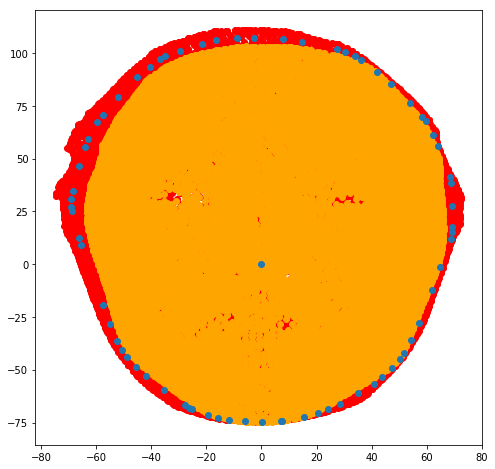

In [14]:

plt.figure(figsize=(8,8))
plt.scatter(points1[:,0], points1[:,1], color="red")
plt.scatter(points2[:,0], points2[:,1], color="orange")

plt.scatter(hull[:,0], hull[:,1])
maxind = np.argmax(points1[:,2])
nosex = points1[maxind,0]
nosey = points1[maxind,1]
nosez = points1[maxind,2]
plt.plot(nosex,nosey,"b")
plt.show()


## Triangulation 

In [15]:
def delaunay_triangulation(hull):
    points2D=np.vstack([hull[:,0],hull[:,1]]).T
    tri_hull = Delaunay(points2D)
    ipv.figure()
    mesh = ipv.plot_trisurf(hull[:,0], hull[:,1], hull[:,2], triangles=tri_hull.simplices, color='blue')
    ipv.scatter(hull[:,0], hull[:,1], hull[:,2], marker='sphere', color='red')
    ipv.show()
    return tri_hull

In [16]:
tri_hull = delaunay_triangulation(hull)

## Geodesic Patch Extraction

In [17]:
def get_patch(points, hull, x1, y1, z1):
    patch_width = 5 * rho
    def distance(x,y,z,x1,y1,z1,x2,y2,z2):
        a = (y2-y1)/(x2-x1)
        b = -1
        c = y2-x2*(y2-y1)/(x2-x1)
        return abs(a*x+b*y+c)/(a**2+b**2)**0.5

    patch = []
    nosex, nosey, nosez = hull[0]
    for x2,y2,z2 in points:
        if (y1-nosey)/(y2-nosey+0.0001)>0 and (x1-nosex)/(x2-nosex+0.0001)>0 \
        and distance(x2,y2,z2,x1,y1,z1,nosex,nosey,nosez)<patch_width:
            patch.append([x2,y2,z2])
    patch = np.array(patch)
    return patch

In [18]:
x1, y1, z1 = hull[70, :]
patch1 = get_patch(points1, hull, x1, y1, z1)


In [19]:
ipv.clear()
ipv.quickscatter(points1[:,0],points1[:,1],points1[:,2], size=1, marker="sphere", color="red")
ipv.scatter(patch1[:,0], patch1[:,1], patch1[:,2], size=1, marker="sphere", color="blue")
ipv.show()

In [20]:
patch2 = get_patch(points2, hull, x1, y1, z1)

In [21]:
ipv.quickscatter(patch1[:,0], patch1[:,1], patch1[:,2], size=2, marker="sphere", color="red")
ipv.scatter(patch2[:,0],patch2[:,1],patch2[:,2], size=2, marker="sphere", color="blue")
ipv.show()

## Keypoint Extraction

In [22]:
def is_keypoint(point, points):
    threshold = 7 * rho
    nhood = points[(np.sum(np.square(points-point),axis=1)) < threshold**2]
    try:
        nhood = (nhood - np.min(nhood, axis=0)) / (np.max(nhood, axis=0) - np.min(nhood, axis=0))
        covmat = np.cov(nhood)
        eigvals = np.sort(np.abs(np.linalg.eigvalsh(covmat)))
        ratio = eigvals[-1]/(eigvals[-2]+0.0001)
        return ratio>30 #eigen_ratio_threshold #/ 5
    except Exception as e:
        return False

ipv.clear()

ipv.scatter(points2[:,0],points2[:,1],points2[:,2], size=1, marker="sphere", color="blue")
keypoints = patch2[np.apply_along_axis(is_keypoint, 1, patch2, patch2)]
# print(keypoints)
ipv.scatter(keypoints[:,0],keypoints[:,1],keypoints[:,2], size=2, marker="sphere", color="red")
ipv.show()

In [23]:
def get_keypoints_from_face(points, plot=False):
    all_keypoints = []
    for idx in range(1, len(hull)-1):
        x1, y1, z1 = hull[idx, :]
        patch = get_patch(points, hull, x1, y1, z1)
        keypoints = list(patch[np.apply_along_axis(is_keypoint, 1, patch, patch)])
        all_keypoints.extend(keypoints)
    all_keypoints = np.array(all_keypoints)
    if plot:
        ipv.clear()
        ipv.scatter(points[:,0],points[:,1],points[:,2], size=1, marker="sphere", color="blue")
        print("Number of keypoints: ", all_keypoints.shape)
        ipv.scatter(all_keypoints[:, 0], all_keypoints[:, 1], all_keypoints[:, 2], size=1, marker="sphere", color="red")
        ipv.show()
    return all_keypoints

In [24]:
all_keypoints = get_keypoints_from_face(points1,plot=True)

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Number of keypoints:  (1882, 3)


In [25]:

all_keypoints = get_keypoints_from_face(points2,plot=True)

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Number of keypoints:  (1894, 3)


## Feature Extraction

In [26]:

def get_normal(x, y, grid_x, grid_y, grid_z):
    '''
      3
    1   2
      4
    '''
    i = (x - grid_x[0, 0]) / (grid_x[1, 0] - grid_x[0, 0])
    j = (y - grid_y[0, 0]) / (grid_y[0, 1] - grid_y[0, 0])
    i,j = int(round(i)), int(round(j))
    print(i, j)
    if (not 0 <= i < grid_x.shape[0]) or (not 0 <= j < grid_y.shape[1]):
        raise "shape error"
    print(i,j)
    point1 = (grid_x[i-1, j], grid_y[i-1, j], grid_z[i-1, j])
    point2 = (grid_x[i+1, j], grid_y[i+1, j], grid_z[i+1, j])
    point3 = (grid_x[i, j-1], grid_y[i, j-1], grid_z[i, j-1])
    point4 = (grid_x[i, j+1], grid_y[i, j+1], grid_z[i, j+1])
    a1, a2, a3 = [point2[x] - point1[x] for x in range(3)]
    b1, b2, b3 = [point3[x] - point4[x] for x in range(3)]
    normal = np.array([a3*b2, a1*b3, -a1*b2])
    return normal/np.linalg.norm(normal)



In [27]:

ipv.clear()
ipv.plot_mesh(grid_x, grid_y, zi, wireframe=False)

uvn = get_normal(60, 20, grid_x,grid_y,zi)
print(zi[269, 190])
print(uvn)
ipv.quiver(np.array([60.]), np.array([20.]), np.array([zi[269, 190]]), np.array([uvn[0]]), np.array([uvn[1]]), np.array([uvn[2]]), color="blue", size=10)
#ipv.scatter(np.array([10, ]), np.array([10, ]), np.array([10, ]), color="blue", size=5)
#ipv.quickquiver(np.array([-1.0]), np.array([0.25817214]), np.array( [0.42129626]), np.array([uvn[0]]), np.array([uvn[1]]), np.array([uvn[2]]), size=50)

ipv.show()
print(np.array([40]))

269 190
269 190
-52.12757172054859
[0.78798213 0.05816463 0.61294457]


[40]


In [28]:
xy_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, :2])).flatten()
yz_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, 1:])).flatten()
xz_hu_moments = cv2.HuMoments(cv2.moments(patch2[:, ::2])).flatten()
hu_moments = np.concatenate([xy_hu_moments, yz_hu_moments, xz_hu_moments])
hu_moments.shape


(21,)

In [29]:
hu_moments

array([ 4.46832228e-01,  1.99841678e-01,  5.53289084e-05,  5.54389571e-05,
        3.07042250e-09,  2.47826630e-05,  4.60688698e-12, -3.35959618e-01,
        1.12816197e-01,  1.03715467e-03,  1.03752708e-03,  1.07626923e-06,
       -3.48485850e-04,  5.08091445e-11,  1.41937453e+00,  2.51229635e+00,
        4.17397159e+00,  1.85485717e+00,  4.89527342e+00,  2.79582917e+00,
       -1.63493979e+00])

In [30]:
moments = cv2.moments(patch2[:, :2])
central_moments = [moments[key] for key in moments.keys() if key[:2] == "mu"]
central_moments = np.array(central_moments)
central_moments

array([-9.57519989e+02, -6.82944274e+02,  4.18942554e+06, -1.43659468e+03,
       -1.02464087e+03,  1.52444158e+04, -3.86080528e+06])

In [31]:
def points2meshgrid(points):
    [X, Y] = meshgrid(points[:,0], points[:,1])
    Z = interpolate.griddata((patch1[:, 0], patch1[:, 1]), patch1[:, 2], (X, Y), method='cubic')
    print(X.shape, Y.shape, Z.shape)
    ipv.figure()
    ipv.scatter(points[:,0],points[:,1],points[:,2])
#     ipv.scatter(X.reshape(-1), Y.reshape(-1), Z.reshape(-1), color="orange")
    ipv.show()
    
points2meshgrid(patch1)

(132, 132) (132, 132) (132, 132)


In [32]:
def surface_curvature(X,Y,Z):

    (lr,lb)=X.shape


    #First Derivatives
    Xv,Xu=np.gradient(X)
    Yv,Yu=np.gradient(Y)
    Zv,Zu=np.gradient(Z)

    #Second Derivatives
    Xuv,Xuu=np.gradient(Xu)
    Yuv,Yuu=np.gradient(Yu)
    Zuv,Zuu=np.gradient(Zu)   

    Xvv,Xuv=np.gradient(Xv)
    Yvv,Yuv=np.gradient(Yv)
    Zvv,Zuv=np.gradient(Zv) 

    #2D to 1D conversion 
    #Reshape to 1D vectors
    Xu=np.reshape(Xu,lr*lb)
    Yu=np.reshape(Yu,lr*lb)
    Zu=np.reshape(Zu,lr*lb)
    Xv=np.reshape(Xv,lr*lb)
    Yv=np.reshape(Yv,lr*lb)
    Zv=np.reshape(Zv,lr*lb)
    Xuu=np.reshape(Xuu,lr*lb)
    Yuu=np.reshape(Yuu,lr*lb)
    Zuu=np.reshape(Zuu,lr*lb)
    Xuv=np.reshape(Xuv,lr*lb)
    Yuv=np.reshape(Yuv,lr*lb)
    Zuv=np.reshape(Zuv,lr*lb)
    Xvv=np.reshape(Xvv,lr*lb)
    Yvv=np.reshape(Yvv,lr*lb)
    Zvv=np.reshape(Zvv,lr*lb)

    Xu=np.c_[Xu, Yu, Zu]
    Xv=np.c_[Xv, Yv, Zv]
    Xuu=np.c_[Xuu, Yuu, Zuu]
    Xuv=np.c_[Xuv, Yuv, Zuv]
    Xvv=np.c_[Xvv, Yvv, Zvv]

    #% First fundamental Coeffecients of the surface (E,F,G)
    E=np.einsum('ij,ij->i', Xu, Xu) 
    F=np.einsum('ij,ij->i', Xu, Xv) 
    G=np.einsum('ij,ij->i', Xv, Xv) 

    m=np.cross(Xu,Xv,axisa=1, axisb=1) 
    p=np.sqrt(np.einsum('ij,ij->i', m, m)) 
    n=m/np.c_[p,p,p]
    # n is the normal
    #% Second fundamental Coeffecients of the surface (L,M,N), (e,f,g)
    L= np.einsum('ij,ij->i', Xuu, n) #e
    M= np.einsum('ij,ij->i', Xuv, n) #f
    N= np.einsum('ij,ij->i', Xvv, n) #g

    # Alternative formula for gaussian curvature in wiki 
    # K = det(second fundamental) / det(first fundamental)
    #% Gaussian Curvature
    K=(L*N-M**2)/(E*G-L**2)
    K=np.reshape(K,lr*lb)
    #wiki trace of (second fundamental)(first fundamental inverse)
    #% Mean Curvature
    H = (E*N + G*L - 2*F*M)/((E*G - F**2))
    H = np.reshape(H,lr*lb)

    #% Principle Curvatures
    Pmax = H + np.sqrt(H**2 - K)
    Pmin = H - np.sqrt(H**2 - K)
    #[Pmax, Pmin]
    return [Pmax, Pmin, G, H]


def fun(x,y):
    return x**2+y**2

In [33]:
x1, y1, z1 = patch1[:, 0], patch1[:, 1], patch1[:, 2]

In [34]:
[pgrid_x,pgrid_y] = scipy.meshgrid(x1, y1)

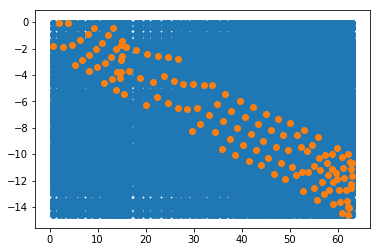

In [35]:
plt.scatter(pgrid_x, pgrid_y);
plt.scatter(x1, y1)

In [36]:
pgrid_z = scipy.interpolate.griddata((patch1[:, 0], patch1[:, 1]), patch1[:, 2], (pgrid_x, pgrid_y), method='cubic')

/home/ags/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


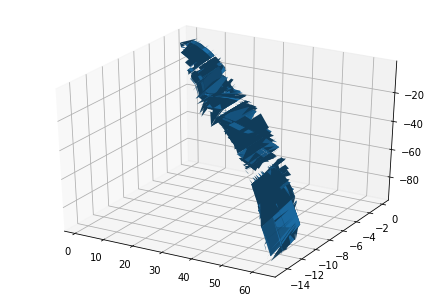

In [37]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(pgrid_x,pgrid_y,pgrid_z)
plt.show()

In [38]:
ipv.figure()
ipv.plot_surface(pgrid_x, pgrid_z, pgrid_y)
ipv.show()

In [39]:
k1, k2, G, H = surface_curvature(pgrid_x,pgrid_y,pgrid_z)

/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in sqrt
/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in sqrt


In [40]:
k1, k2, G, H

(array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([        nan,  0.17418816,         nan, ..., 81.78032115,
                nan, 75.26359347]),
 array([nan, nan, nan, ..., nan, nan, nan]))

In [41]:
for i in range(len(patch1)):
    print(k1[i*i])

nan
nan
nan
nan
nan
nan
0.048781641187741545
nan
nan
nan
1.504569882221884
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.014603650254780928
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0.04661671443542394
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
-0.0027540640601607796
nan
nan
62.08805730340325
nan
nan
nan
nan
nan
0.1299623247956001
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [42]:
# Shape index

Sa = 1/2 - 1/np.pi * np.arctan((k1+k2)/(k1-k2))
Sb = 2/np.pi * np.arctan((k1+k2)/(k1-k2))

print(Sa)
print(Sb)

[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]


In [43]:
curvedness = np.sqrt((k1**2 + k2**2)/2)
log_curvedness = 2/np.pi * np.log10(curvedness)
willmore_energy = H**2 - G
shape_curvedness = Sb * log_curvedness
log_difference_map = np.log(G - H + 1) 


/home/ags/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
